# 18-13. 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

* 데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.
* sunnysai12345/News_Summary
* https://github.com/sunnysai12345/News_Summary

In [1]:
import pandas as pd
import urllib.request

# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [2]:
data.sample(10)

,headlines,text
24474,Google Chrome now marks all HTTP sites as 'not...,Google has updated its Chrome browser to inclu...
73189,Took me 3 yrs to convince B'wood I can be glam...,Taapsee Pannu has said it took her three years...
40539,India announces 30-day free visa for Indonesia...,Prime Minister Narendra Modi on Wednesday anno...
98219,Why are crushed stones placed along railway tr...,The crushed stones placed along the railway tr...
6848,Release date of Nutan's granddaughter's debut ...,The release date of Nutan's granddaughter and ...
20128,We speak daily: Kangana denies tiff with 'Mani...,Denying rumours of her tiff with her upcoming ...
93472,Teaser of Star Wars: The Last Jedi released,The teaser of 'Star Wars: The Last Jedi' was r...
83255,Ravi Shastri to apply for India head coach post,Former cricketer Ravi Shastri has confirmed he...
33690,"Jong-un allows S Korean head to cross line, 'v...","During the on-going Korea Summit, South Korean..."
5231,"We wanted Kumble to continue as coach, he want...",Ex-India batsman and BCCI's Cricket Advisory C...


* 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성됨

추상적 요약을 하는 경우에는 
* text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 

추출적 요약을 하는 경우에는 
* 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)

* 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
* 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요

In [3]:
# 패키지 호출
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 전처리 - 중복 제거, NULL 제거

In [4]:
# 전체 data 수 확인
print('전체 data 수 : ', len(data))

전체 data 수 :  98401


In [5]:
# 각 열별 유일한 샘플 수 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
# 중복 값 제거
data.drop_duplicates(subset = ['headlines'], inplace = True)
data.drop_duplicates(subset = ['text'], inplace = True)

# 중복 제거 후 전체 data갯수 확인
print('중복 제거 후 전체 샘플수 :', len(data))

중복 제거 후 전체 샘플수 : 98262


In [7]:
# 열별 null 갯수 확인 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


=> 제거할 null 없음

### 텍스트 정규화, 불용어 제거

### 텍스트 정규화(text normalization)

* 기계 학습 전에 '같은 의미 다른 표현 단어'를 미리 같은 표현으로 통일시켜주는 것
* 예시 'it'll'은 'it will'과 같고, 'mustn't과 'must not'은 사실 같은 표현

* 여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
* 이 사전은 아래의 링크에서 참고하여 만들었어요. 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120



### 불용어(stopwords) 제거

* 불용어 : 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어
* 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* 텍스트 정규화, 불용어 제거 수행하는 전처리 함수 설계

In [10]:
# 데이터 전처리 함수
# 함수의 2번째 인자를 False로 설정하면 불용어는 제거되지 않음
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z0-9.',]", " ", sentence) # 영어,숫자 외 문자(특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# data[text]에 대하여 함수 실행

clean_text = []

# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있음. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

["saurav kant, alumnus upgrad iiit b's pg program machine learning artificial intelligence, sr systems engineer infosys almost years work experience. program upgrad's 360 degree career support helped transition data scientist tech mahindra 90 salary hike. upgrad's online power learning powered lakh careers.",
 "kunal shah's credit card bill payment platform, cred, gave users chance win free food swiggy one year. pranav kaushik, delhi techie, bagged reward spending 2000 cred coins. users get one cred coin per rupee bill paid, used avail rewards brands like ixigo, bookmyshow, ubereats, cult.fit more.",
 "new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series. india lost international match rohit sharma's captaincy 12 consecutive victories dating back march 2018. match witnessed india getting 92, seventh lowest total odi cricket history.",
 'aegon life iterm insurance plan, customers enjoy tax benefits premiums paid save 46,800 taxes. plan pr

In [12]:
# data[headlines]에 대하여 함수 실행
clean_headlines = []

# 전체 data[headlines] 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있음. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    # headlines에 대해서 전처리 함수를 호출해줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣음
    
clean_headlines[:5]

['upgrad learner switches to career in ml al with 90 salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 "new zealand end rohit sharma led india's 12 match winning streak",
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs, what if metoo claims are not true sonam']

In [13]:
# 다시 data 변수에 넣어주기
data['text'] = clean_text
data['headlines'] = clean_headlines

### 전처리(정규화, 불용어 제거) 후 NULL 값 재확인 및 제거

In [14]:
# 빈 값('')을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null 값 존재 재확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

=> Null 없음

### 샘플 최대 길이 설정

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.57175713907716
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 57
텍스트의 평균 길이 : 36.61832651482771


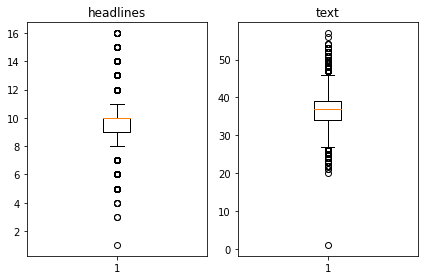

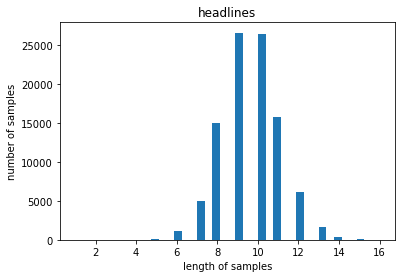

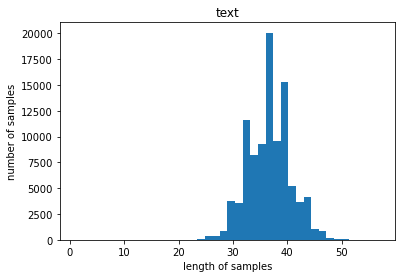

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]


print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# headlines와 text의 적절한 최대 길이를 지정
headlines_max_len = 12
text_max_len = 45

In [17]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
# 지정한 최대 길이가 몇 % 샘플을 포함하는지 확인
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9791984693981397
전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9880014654698662


In [19]:
# 정한 길이 보다 길면 데이터 제외하는 방식으로 정제
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('현재 전체 샘플수 :',(len(data)))

현재 전체 샘플수 : 95086


### 시작 토큰과 종료 토큰 추가하기

* 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명
* decoder_input : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
* decoder_target : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름

In [20]:
# 헤드라인 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"saurav kant, alumnus upgrad iiit b's pg progra...",sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india's 12 ma...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india's 12 ma...
3,aegon life iterm insurance plan helps customer...,"aegon life iterm insurance plan, customers enj...",sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리

In [22]:
# encoder_input의 데이터 갯수와 같은 정수 시퀀스 만들기
# (이 정수 시퀀스를 이용해서 샘플 데이터를 섞기 수행)

indices = np.arange(encoder_input.shape[0])
# np.arange : 시작 숫자와 끝 숫자를 주어주면 일정한 간격의 배열을 만들어줌

# 순서를 섞어줌
np.random.shuffle(indices)
print(indices)

[39964 16870 73879 ... 55643 21927  9085]


In [23]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
# 리스트를 이용해 순서 섞기!!!
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# n_of_val : 테스트 데이터의 수
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19017


In [25]:
# 데이터 분리 수행
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 76069
훈련 레이블의 개수 : 76069
테스트 데이터의 개수 : 19017
테스트 레이블의 개수 : 19017


In [26]:
# 데이터 확인
print(encoder_input_train[0])

consortium private equity firm tpg manipal health nearing deal acquire india's second largest hospital chain fortis healthcare, according reports. operations manipal, backed tpg, would combined fortis' business, reports added. notably, fortis probed fraud reports said promoters took 500 crore without board approval.


### 정수 인코딩
    * Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합


temp = 0  # key, value 값 확인용 변수

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# key : Tokenizer에 포함된 단어
# value : 각 단어별 등장 빈도 수
for key, value in src_tokenizer.word_counts.items():   
    
    # key, value 값 확인용 코드
    if temp <= 3:
        print('key : ', key)
        print('value : ', value)
        print(type(value))
        temp += 1
        
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면(6번 이하로 등장한 단어는 제외)
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

key :  consortium
value :  72
<class 'int'>
key :  private
value :  1135
<class 'int'>
key :  equity
value :  199
<class 'int'>
key :  firm
value :  1235
<class 'int'>
단어 집합(vocabulary)의 크기 : 86509
등장 빈도가 6번 이하인 희귀 단어의 수: 62635
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23874
단어 집합에서 희귀 단어의 비율: 72.40287137754453
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.331467225749788


In [29]:
# num_words를 설정하여 토크나이저를 정의할 때 단어 집합의 크기를 제한
src_vocab = 21900
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21,900으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [31]:
#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5647, 388, 2543, 330, 13520, 11722, 439, 16899, 249, 2577, 99, 100, 334, 199, 1757, 5164, 2398, 48, 29, 748, 11722, 1537, 13520, 21, 2578, 364, 29, 2, 108, 5164, 7159, 1039, 29, 1, 5433, 74, 299, 18, 200, 192, 1806], [75, 863, 1415, 32, 3320, 1, 538, 4700, 13965, 3320, 1963, 21, 312, 306, 1339, 1963, 609, 2722, 5487, 8523, 6872, 2, 863, 1, 580, 1339, 7267, 3320, 54, 851, 11428, 2454, 10031], [2837, 94, 20, 1289, 69, 3670, 72, 497, 22, 118, 1256, 4936, 185, 246, 13099, 622, 114, 986, 256, 25, 735, 776, 2953, 942, 1112, 190, 78, 1912, 44, 1559, 14451, 13099, 1610, 1256, 648]]


### headlines 데이터 정수 인코딩

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
# 등장 횟수 5회 이하 분포율 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39109
등장 빈도가 5번 이하인 희귀 단어의 수: 28068
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11041
단어 집합에서 희귀 단어의 비율: 71.76864660308368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.251559054489578


In [34]:
# 10334를 어림잡아 10000개로 설정
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9986, 3, 416, 2907, 2628, 55], [1, 1975, 6, 9167, 96, 2908, 910, 19, 794, 471, 406], [1, 3330, 129, 2375, 147, 2782, 308, 778, 2221, 110, 646, 39], [1, 511, 597, 411, 1214, 3, 3905, 3906, 821, 17, 1814], [1, 92, 1509, 4152, 7, 516, 1815, 1041, 2424]]
target
decoder  [[9986, 3, 416, 2907, 2628, 55, 2], [1975, 6, 9167, 96, 2908, 910, 19, 794, 471, 406, 2], [3330, 129, 2375, 147, 2782, 308, 778, 2221, 110, 646, 39, 2], [511, 597, 411, 1214, 3, 3905, 3906, 821, 17, 1814, 2], [92, 1509, 4152, 7, 516, 1815, 1041, 2424, 2]]


* 빈도수 낮은 단어 제거 후 Null data 확인

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1


=> NULL data 없음

### 패딩하기

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 작업
* 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이를 맞춰줆

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

* 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
* 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2803200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2803200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
# 설계한 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
298/298 [==============================] - 87s 293ms/step - loss: 5.6725 - val_loss: 5.2753
Epoch 2/50
298/298 [==============================] - 87s 291ms/step - loss: 5.1043 - val_loss: 4.9034
Epoch 3/50
298/298 [==============================] - 87s 291ms/step - loss: 4.7541 - val_loss: 4.6075
Epoch 4/50
298/298 [==============================] - 87s 291ms/step - loss: 4.4907 - val_loss: 4.4462
Epoch 5/50
298/298 [==============================] - 87s 291ms/step - loss: 4.2812 - val_loss: 4.2810
Epoch 6/50
298/298 [==============================] - 87s 292ms/step - loss: 4.1047 - val_loss: 4.1744
Epoch 7/50
298/298 [==============================] - 87s 291ms/step - loss: 3.9546 - val_loss: 4.0656
Epoch 8/50
298/298 [==============================] - 87s 291ms/step - loss: 3.8274 - val_loss: 3.9969
Epoch 9/50
298/298 [==============================] - 87s 291ms/step - loss: 3.7130 - val_loss: 3.9305
Epoch 10/50
298/298 [==============================] - 87s 292ms/step - l

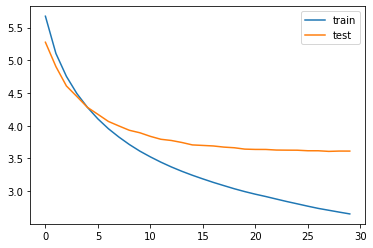

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 18-10. 인퍼런스 모델 구현하기

    * 인퍼런스 모델 : 훈련 할 때 모델과 다른 실제 동작 모델

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 설계

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

* 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : composer duo salim dedicated song titled 'mera desh hi armed forces occasion india's 71st independence day tuesday talking idea behind song salim said months back met pm narendra modi suggested we make song country song penned sandeep shrivastava 
실제 요약 : song to armed forces on day 
예측 요약 :  music song from eid to be part of independence day


원문 : emma watson winning first ever best actor movie award mtv movie tv awards said shows acting need separated two different categories indicates acting ability put someone else's shoes added emma beauty beast 
실제 요약 : acting does not need two emma on award 
예측 요약 :  emma watson awards best award for best actor


원문 : former manchester united captain wayne rooney scored curling free kick playing new club dc united taking free kick around 25 yards out rooney placed kick top right beyond reach diving goalkeeper previous match rooney created assist right match saving tackle 
실제 요약 : rooney scores with free kick for his new club 
예측 요약 :  roon

예측 요약 :  player scores from his own goal by


원문 : cnn news 18 claimed audio tapes reveal pakistan funding terror outfit hizbul mujahideen carrying chemical attack kashmir according weapons attack already received plan next move eid will use chemical weapons hizbul operative reportedly says tapes 
실제 요약 : pakistan hizbul for chemical attack in kashmir report 
예측 요약 :  cnn anchor calls for isis attack on isis


원문 : angelina jolie filed divorce brad pitt september 2016 reportedly dating justin announced split earlier year jennifer aniston two half years marriage earlier aniston married brad 2000 2005 got separated brad allegedly left jolie 
실제 요약 : estranged wife jolie dating 1st wife's ex husband reports 
예측 요약 :  angelina jolie to get engaged to girlfriend reports


원문 : tesla spacex's billionaire ceo elon musk thursday said might visit india early next year february last year 47 year old entrepreneur said tesla cars could hit indian roads early summer 2017 however may tweeted challen

예측 요약 :  man arrested for heart attack while taking selfie at


원문 : mumbai police registered least 455 cases drunk driving till new year's day official said actions like imposition fine driving licenses taken them added till midnight december 31 police caught total 1 people 76 found drunk 
실제 요약 : people caught drunk driving in mumbai on new year 
예측 요약 :  mumbai police to get bullet proof for taxi drivers


원문 : policemen deployed inner kashi vishwanath temple uttar pradesh's varanasi wear yellow white duty instead official uniform decision aimed ensuring atmosphere reportedly suggested prime minister's office incidentally varanasi also pm narendra modi's parliamentary constituency 
실제 요약 : cops at temple to wear on duty 
예측 요약 :  cops protest in telangana temple after residents




## Step 5. Summa을 이용해서 추출적 요약해보기

* 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 
* 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

* Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [65]:
# 패키지 설치
import requests
from summa.summarizer import summarize

In [66]:
# 요약할 text 저장
origin_text = data['text'][26]
print('원본 문장 : ', origin_text)

원본 문장 :  london zoo offering people name cockroach exes valentine's day 1.50 quite require revenge, another way make feel better getting back ex, zoo said statement. names appear zoo's 'roach board' february 14.


In [67]:
)#  headlines 원본 출력
origin_headlines = data['headlines'][20]
print('원본 headlines : ', origin_headlines)

원본 headlines :  think the opposition even dreams about me pm modi


In [82]:
#  summa를 사용한 요약본 출력
print('추출적 요약본 : ')
print(summarize(origin_text, ratio = 0.5))

추출적 요약본 : 
london zoo offering people name cockroach exes valentine's day 1.50 quite require revenge, another way make feel better getting back ex, zoo said statement.
